In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo



In [2]:
#Read in the LOFAR data both optical and radio
lofar_rad = Table.read('data/radio/EN1_ML_RUN_fin_overlap_srl_workflow.fits')
lofar_opt = Table.read('data/optical/EN1_MASTER_opt_spitzer_merged_cedit_apcorr.fits')
lofar_opt.rename_column('ALPHA_J2000','ra')
lofar_opt.rename_column('DELTA_J2000','dec')

In [79]:
LR_suitable = pickle.load(open('data/LR/sources_to_send_to_lr.pckl','rb'))
lofar_rad = lofar_rad[LR_suitable]

In [80]:
#merge the optical and radio catalogue to find out which optical sources need crossmatching to HELP
mask = ~np.isnan(lofar_rad['lr_index_fin'])
lofar = hstack([lofar_rad[mask],lofar_opt[lofar_rad[mask]['lr_index_fin'].astype(int)]])

In [83]:
#comparing with the help masterlist from fits file
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')

In [84]:
prior_mask = (masterlist['flag_optnir_det']>=5) & (masterlist['f_mips_24']>20)

In [85]:
ra = lofar['ra']
dec = lofar['dec']
#Crossmatch the lofar source with the help masterlist
lofar_coords = SkyCoord(ra,dec,unit='deg')
help_coords = SkyCoord(masterlist['ra'],masterlist['dec'],unit='deg')
radius = 2
idx_help, idx_lofar, d2d, d3d = lofar_coords.search_around_sky(
    help_coords, radius*u.arcsec)
d2d = d2d.value
ids,counts = np.unique(idx_lofar,return_counts=True)

In [86]:
#look at sources with no crossmatch
x = []
y = []
for n in range(len(lofar)):
    if n not in ids:
        x.append(ra[n])
        y.append(dec[n])
print('number of radio sources with no help source within 2 arcseconds is: {}'.format(len(ra)-len(ids)))

number of radio sources with no help source within 2 arcseconds is: 45


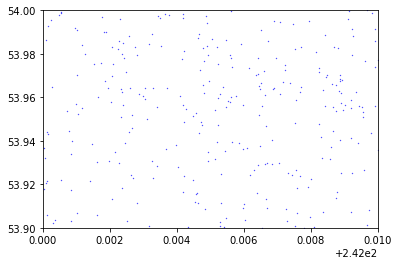

In [87]:
plt.scatter(x,y,c='red',s=10)
plt.scatter(masterlist['ra'],masterlist['dec'],s=0.1,c='blue')


plt.xlim(242,242.01)
plt.ylim(53.9,54)
plt.show()

In [ ]:
for n in range(len(ids)):
    if counts[n]>1:
        mask = idx_lofar==ids[n]
        for m in range(len(d2d[mask])):
            print('distance to object is {} arcseconds and is in prior list = {}'.format(d2d[mask][m]*3600,prior_mask[idx_help[mask][m]]))
        print('...........')
            

In [88]:
num_spire_far = 0
num_spire_far_sep_diff = []
idx_spire_far_help = []
idx_spire_far_lofar = []
num_spire_near = 0
num_nspire_more = 0

num_spire_more = 0
for n in range(len(ids)):
    if counts[n]>1:
        mask = idx_lofar==ids[n]
        seperations = d2d[mask]
        priors = prior_mask[idx_help[mask]]
        
        if np.sum(priors)==0:
            num_nspire_more = num_nspire_more+1
            
        if np.sum(priors)==1:
            mask_sep = seperations==np.min(seperations)
            if priors[mask_sep]==True:
                num_spire_near = num_spire_near+1
            if priors[mask_sep]==False:
                num_spire_far = num_spire_far+1
                sep_diff = seperations[priors]-np.min(seperations)
                num_spire_far_sep_diff.append(sep_diff[0])
                for i in range(np.sum(mask)):
                    idx_spire_far_help.append(idx_help[mask][i])
                    idx_spire_far_lofar.append(idx_lofar[mask][i])
        if np.sum(priors)>1:
            num_spire_more = num_spire_more+1
print('number of radio sources with no possible prior list object but with multiple sources is: {}'.format(num_nspire_more))
print('number of radio sources with multiple nearby help objects but the nearest is in the prior list is: {}'.format(num_spire_near))
print('number of radio sources with multiple nearby help objects but the nearest is not in the prior list is: {}'.format(num_spire_far))
print('number of radio sources with nultiple sources nearby which are in the prior list is: {}'.format(num_spire_more))
            #print('distance to object is {} arcseconds and is in prior list = {}'.format(d2d[mask][m]*3600,prior_mask[idx_help[mask][m]]))
        #print('...........')
        
idx_spire_far_help = np.array(idx_spire_far_help)
idx_spire_far_lofar = np.array(idx_spire_far_lofar)

number of radio sources with no possible prior list object but with multiple sources is: 1940
number of radio sources with multiple nearby help objects but the nearest is in the prior list is: 6080
number of radio sources with multiple nearby help objects but the nearest is not in the prior list is: 1090
number of radio sources with nultiple sources nearby which are in the prior list is: 79


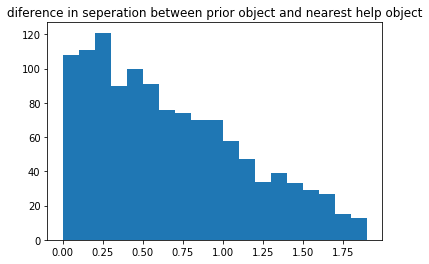

In [24]:
plt.hist(np.array(num_spire_far_sep_diff)*3600,bins=np.arange(0,2,0.1))
plt.title('diference in seperation between prior object and nearest help object')
plt.show()

x = lofar['ra'][idx_spire_far_lofar]
y = lofar['dec'][idx_spire_far_lofar]

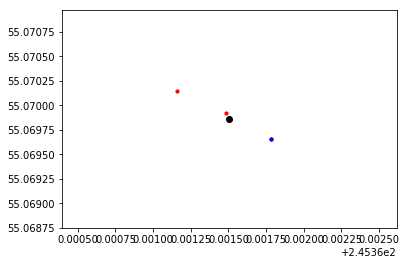

In [71]:
#plots the position of sources near a radio source which has a prior object nearby but isn't the nearest object
idx_spire_far_lofar_unique = np.unique(idx_spire_far_lofar)
lofar_id = idx_spire_far_lofar_unique[6]
mask = idx_spire_far_lofar==lofar_id

x = lofar['ra'][lofar_id]
y = lofar['dec'][lofar_id]
plt.scatter(x,y,c='black')

help_id = idx_spire_far_help[mask]
x = masterlist['ra'][help_id]
y = masterlist['dec'][help_id]
plt.scatter(x,y,c='red',s=10)

x = masterlist['ra'][help_id]
y = masterlist['dec'][help_id]
mask_temp = (masterlist['flag_optnir_det'][help_id]>=5) & (masterlist['f_mips_24'][help_id]>20)
x = x[mask_temp]
y = y[mask_temp]
plt.scatter(x,y,c='blue',s=10)


plt.xlim(lofar['ra'][lofar_id]-4/3600,lofar['ra'][lofar_id]+4/3600)
plt.ylim(lofar['dec'][lofar_id]-4/3600,lofar['dec'][lofar_id]+4/3600)
plt.show()

In [ ]:
#plots the position of sources near a radio source which has a prior object nearby but isn't the nearest object
idx_spire_far_lofar_unique = np.unique(idx_spire_far_lofar)
lofar_id = idx_spire_far_lofar_unique[6]
mask = idx_spire_far_lofar==lofar_id

x = lofar['ra'][lofar_id]
y = lofar['dec'][lofar_id]
plt.scatter(x,y,c='black')

help_id = idx_spire_far_help[mask]
x = masterlist['ra'][help_id]
y = masterlist['dec'][help_id]
plt.scatter(x,y,c='red',s=10)

x = masterlist['ra'][help_id]
y = masterlist['dec'][help_id]
mask_temp = (masterlist['flag_optnir_det'][help_id]>=5) & (masterlist['f_mips_24'][help_id]>20)
x = x[mask_temp]
y = y[mask_temp]
plt.scatter(x,y,c='blue',s=10)


plt.xlim(lofar['ra'][lofar_id]-4/3600,lofar['ra'][lofar_id]+4/3600)
plt.ylim(lofar['dec'][lofar_id]-4/3600,lofar['dec'][lofar_id]+4/3600)
plt.show()

In [50]:
idx_spire_far_lofar

array([  148,   148,   155, ..., 32830, 32830, 32830])

In [54]:
ids_many[30:40]

array([148, 155, 157, 159, 164, 167, 173, 180, 183, 192])